<a href="https://colab.research.google.com/github/Lordd007/Classification/blob/main/Article_topic_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Article topic classification using matrix factorization**

We aim to explore article topic classification under both unsupervised and supervised methods. We will evaluate how well each method can correctly classify articles using the content in these articles. Utilizing matrix factorization for our unsupervised method we will identify patterns and structures in the texts without any labeled examples for it to go off of. We will also take a look at a few supervised methods that achieve the same goal. With the two different methods working towards the same goal, we will be able to compare the strengths and limitations of each method and determine which one is the most accurate.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold, cross_val_score
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import spacy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Load test and training data sets
train_data = pd.read_csv('BBC News Train.csv')
test_data = pd.read_csv('BBC News Test.csv')

In [ ]:
train_data.info

<bound method DataFrame.info of       ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
0          business  
1          business  
2          business  
3              tech  
4          business  
...             ...  
1485  entertainment  
1486  entertainment  
1487       business  
1488           tech  
1489           tech  

[1490 rows x 3 columns]>

In [ ]:
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [ ]:
test_data.info

<bound method DataFrame.info of      ArticleId                                               Text
0         1018  qpr keeper day heads for preston queens park r...
1         1319  software watching while you work software that...
2         1138  d arcy injury adds to ireland woe gordon d arc...
3          459  india s reliance family feud heats up the ongo...
4         1020  boro suffer morrison injury blow middlesbrough...
..         ...                                                ...
730       1923  eu to probe alitalia  state aid  the european ...
731        373  u2 to play at grammy awards show irish rock ba...
732       1704  sport betting rules in spotlight a group of mp...
733        206  alfa romeos  to get gm engines  fiat is to sto...
734        471  citizenship event for 18s touted citizenship c...

[735 rows x 2 columns]>

In [ ]:
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [ ]:
missing_text = train_data['Text'].isnull().sum()
missing_label = train_data['Category'].isnull().sum()
duplicate_text = train_data['Text'].duplicated().sum()
print (missing_text)
print (missing_label)
print (duplicate_text)

0
0
50


Lucky for us in the training data we find no missing values so we don't have to worry about that. We do however have some duplicates that we should get rid of. O let's drop those duplicates and then we can take a look at the categories each duplicate came from.

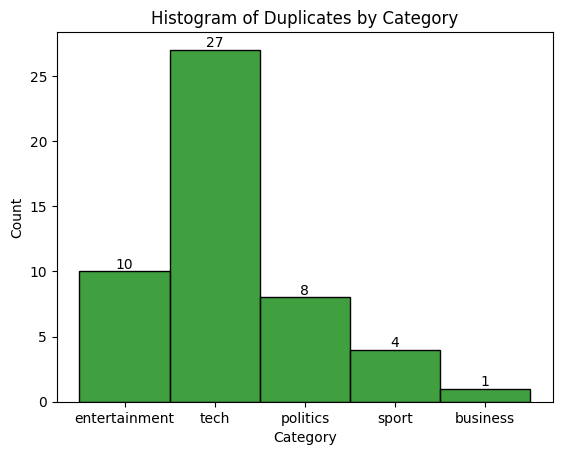

In [ ]:
dupes_dropped = train_data[train_data.duplicated(subset = ['Text'], keep = 'first')]
x = sns.histplot(dupes_dropped['Category'], color = 'green')
plt.title('Histogram of Duplicates by Category')
for p in x.patches:
    x.text(p.get_x() + p.get_width()/ 2,
           p.get_height(),
           '{:.0f}'.format(p.get_height()),
           ha = 'center',
           va = 'bottom'
          )
plt.show()

So a majority of our duplicates are coming from the tech category. We do see a decent amount in both entertainment and politics and even fewer in sports an business.  

Let's drop the duplciates and check by running the shape of the dataset. we shuld see 1440 columns

In [ ]:
train_data = train_data.drop_duplicates(subset= ['Text'])
train_data.shape

(1440, 3)

Okay, next lets check out the distribution of categories in the dataset.

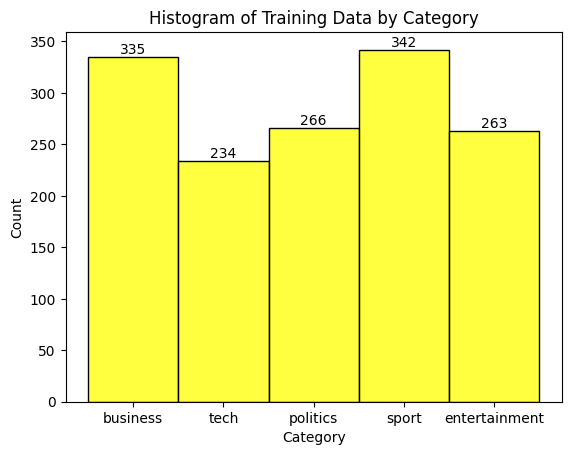

In [ ]:
x = sns.histplot(train_data['Category'], color = 'yellow')
plt.title('Histogram of Training Data by Category')

for p in x.patches:
    x.text(p.get_x() + p.get_width()/ 2,
           p.get_height(),
           '{:.0f}'.format(p.get_height()),
           ha = 'center',
           va = 'bottom'
          )
plt.show()

We should also quickly check out the length of all of these articles and see where they stack up

<ipython-input-15-3127800766>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['text_length'] = train_data['Text'].astype(str).apply(len)


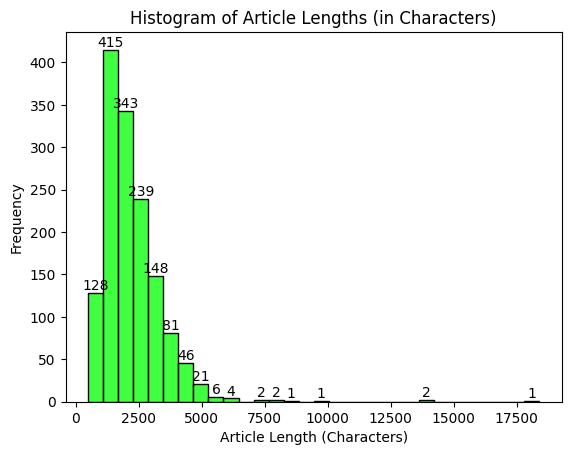

In [ ]:
# Step 1: Compute character lengths for each article
train_data['text_length'] = train_data['Text'].astype(str).apply(len)

# Step 2: Create histogram with Seaborn
x = sns.histplot(train_data['text_length'], bins=30, color='lime')
plt.title('Histogram of Article Lengths (in Characters)')
plt.xlabel('Article Length (Characters)')
plt.ylabel('Frequency')

# Step 3: Add count labels to the bars
for p in x.patches:
    height = p.get_height()
    if height > 0:
        x.text(p.get_x() + p.get_width() / 2,
               height,
               '{:.0f}'.format(height),
               ha='center',
               va='bottom')

plt.show()

We can see that most of our article range from a few hundred to 5000 characters. Very few are longer than that.

Pre Processing

In terms of doing peprocessing we will need to do a couple things like converting words to a simpler root form and excluding other words of low value like 'the'. So we will simplify by placing each text string to a document, convert and extract root words, and leaving out any low value words and puncuation and spaces. This will be achieved via the spacy library

We will then vecorize the using sklearn's TfidVectorizer

In [ ]:
nlp = spacy.load('en_core_web_sm')
documents = list(nlp.pipe(train_data['Text'], disable = ['tok2vec', 'tagger', 'parser',
                                                  'attribute_ruler', 'ner'])
                )

def text_stem(document):
    return ' '.join(
        token.lemma_ for token in document
        if not token.is_stop and not token.is_punct and not token.is_space
    )

/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
train_data.loc[:, 'text_stem'] = [text_stem(doc) for doc in documents]
train_data.loc[4, 'text_stem']

<ipython-input-17-390832154>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'text_stem'] = [text_stem(doc) for doc in documents]


'enron bosses $ 168 m payout eighteen enron directors agreed $ 168 m £ 89 m settlement deal shareholder lawsuit collapse energy firm leading plaintiff university california announced news adding 10 directors pay $ 13 m pockets settlement courts approval week enron went bankrupt 2001 emerged hidden hundreds millions dollars debt collapse firm seventh biggest public company revenue demise sent shockwaves financial markets dented investor confidence corporate america settlement significant holding outside directors partially personally responsible william lerach lawyer leading class action suit enron said hopefully help send message corporate boardrooms importance directors performing legal duties added terms $ 168 m settlement $ 155 m covered insurance 18 directors admit wrongdoing deal fourth major settlement negotiated lawyers filed class action behalf enron s shareholders years ago far including latest deal $ 500 m £ 378.8 m retrieved investors latest deal include enron chief executiv

In [ ]:
vectorizer = TfidfVectorizer(max_features = 5000)
matrix = vectorizer.fit_transform(train_data['text_stem'])
print(matrix.shape)

(1440, 5000)


**Non negative Matrix Factorization**
Non-negative Matrix Factorization (NMF) is a technique to reduce dimensionality by shrinkning a matric that has a shape (*m * n*) into smaller matrices. The first matrix will have shape (*m * d*) and the second (*d * n*)

Therefore: *m * n = (m * d) * (d * n)*

In this form each row of (*m * d*) represents how much a document is associated with each of the *d* topics. While each column of (*d * n*) will show how strong each word contributes to a topic.

For document classification, NMF helps find patterns in how words are used across all our train_data by grouping together documents that speak about similar topics base on the words they contain. So instead of working with a bunch of individual words NMF helps us to reduce the amount to just a few topics. Now, every document is described by how much it relates to each topic making it far easier to compare and classify all the articles. We are going to minimize our current matrix down to just 5 columns down from 5000.

In [ ]:
n_topics = len(train_data['Category'].unique())
nmf = NMF(n_components = n_topics, random_state = 55)
X_nmf = nmf.fit_transform(matrix)
X_nmf.shape

(1440, 5)

Looking at article 4 in our dataset, we can check out how strongly it realtes to each topic.When printed out the topics in our array will be

In [ ]:
topic_labels = [
    "sport",
    "politics",
    "business",
    "entertainment",
    "tech"
]
article_index = 4
topic_weights = X_nmf[article_index, :]

for i, weight in enumerate(topic_weights):
    print(f"{topic_labels[i]}: {weight:.4f}")


sport: 0.0049
politics: 0.0063
business: 0.0695
entertainment: 0.0085
tech: 0.0122


Alright, now that each document has its own weightings. We can add a column to our train_data called 'predicted' that will show us what our model is predicting each article's category is.

In [ ]:
train_data.loc[:, 'predicted'] = X_nmf.argmax(axis=1)
train_data.loc[:, 'predicted'] = train_data['predicted'].apply(lambda i: topic_labels[i])
train_data.head()

<ipython-input-21-4241398513>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'predicted'] = X_nmf.argmax(axis=1)
<ipython-input-21-4241398513>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['business' 'business' 'business' ... 'business' 'tech' 'tech']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[:, 'predicted'] = train_data['predicted'].apply(lambda i: topic_labels[i])


,ArticleId,Text,Category,text_length,text_stem,predicted
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business,3104,bbc poll indicates economic gloom citizens maj...,business
3,1976,lifestyle governs mobile choice faster bett...,tech,3618,lifestyle governs mobile choice faster better ...,tech
4,917,enron bosses in $168m payout eighteen former e...,business,2190,enron bosses $ 168 m payout eighteen enron dir...,business


At first glance in the first few rows it looks like everything was predicted as it should be. I'm sure we will find some discrepancies throughout the entirety og the dataset. We will make a confusion matrix now to see where there are errors

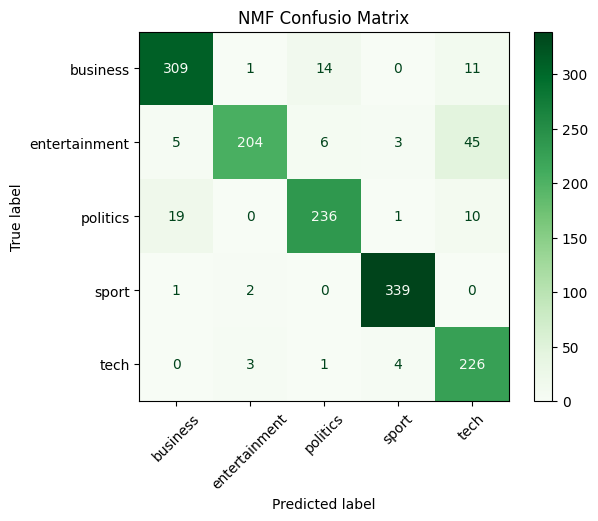

In [ ]:
cmatrix = confusion_matrix(train_data['Category'], train_data['predicted'])
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = np.unique(train_data['Category']))
display.plot(cmap = 'Greens', xticks_rotation = 45)
plt.title('NMF Confusio Matrix')
plt.show()

In [ ]:
print(f'Accuracy: {accuracy_score(train_data["Category"], train_data["predicted"]):.2%}')

Accuracy: 91.25%


Now lets observe our confusion matrix. Overall we performed well with 91.25% total accuracy. Our biggest discrepancy being labeled tech when the real category is entertainment, followed by both business and politics being mistaken for one another.

So let's now approach this using some supervised methods and compre our results!
We will be using K nearest neighbors, multinomial naive bayes, and logistc regression as classifiers.

In [ ]:
models = [KNeighborsClassifier(n_neighbors = 5),
          MultinomialNB(alpha= 0.01),
          LogisticRegression(penalty= 'l2',
                             class_weight = 'balanced',
                             multi_class = 'multinomial',
                             random_state = 0)]

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

cross_val_result = [
    (model.__class__.__name__, fold_idx, acc)
    for model in models
    for fold_idx, acc in enumerate(cross_val_score(model, matrix, train_data.Category, scoring='accuracy', cv=kf))
]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

In [ ]:
res = pd.DataFrame(cross_val_result, columns=['Classifier', 'Folds', 'Accuracy'])
res.groupby('Classifier', as_index=False)['Accuracy'].mean()

,Classifier,Accuracy
0,KNeighborsClassifier,0.931250
1,LogisticRegression,0.975000
2,MultinomialNB,0.972222


**Conclusion**

Clearly we see the accuracy score for each of the supervised methods. Each performed well but Logistic regression is our best by a hair. Interesting to note that all supervised methods performed better than our unspervised method of NMF(91.25%). Based on these finding our final model would include Logistic regression as it performed marginally better than Multinomial Naive Bayes.  